In [1]:
import geopandas as gpd
import shapely.geometry as Point
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


In [2]:
# API helper - Current Police API has a rate limit of 15 requests per second with a burst of 30
def get_api_response(url, retries = 5, backoff=1):
    for i in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"You have exceeded the rate limit. Waiting {backoff} seconds...")
            time.sleep(backoff)
            backoff *= 2
        else:
            print(f"Error {response.status_code} - {response.text}")
            return None
    return None

In [3]:
# List of Bristol area outcodes (first half of postcode)
outcodes = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BS8', 'BS9', 'BS10', 'BS11', 'BS13', 'BS14', 'BS15', 'BS16', 'BS30', 'BS34']

def fetch_postcodes_from_outcodes(outcodes):
    all_postcodes = []

    for outcode in outcodes:
        url = f"https://api.postcodes.io/outcodes/{outcode}"
        result = get_api_response(url)

        if not result or not result.get('result'):
            continue

        lat = result['result']['latitude']
        lng = result['result']['longitude']

        # Fetch postcodes in this area
        postcodes_response = get_api_response(f"https://api.postcodes.io/postcodes?lon={lng}&lat={lat}&radius=3000")
        data = postcodes_response.get('result', [])

        if not data:
            return []
        
        all_postcodes.extend([p['postcode'] for p in data])
        time.sleep(1)

    return list(set(all_postcodes))

In [4]:
def get_lat_lng(postcode):
    url = f"https://api.postcodes.io/postcodes/{postcode}"
    result = get_api_response(url)
    if result and result.get('result'):
        return result['result']['latitude'], result['result']['longitude']
    return None, None

In [50]:
# Get data for past N months
def generate_months(n):
    base = datetime.today().replace(day=1)
    return [(base - relativedelta(months=i)).strftime("%Y-%m") for i in range(n)]
    # Check if the months generated cover the desired range
    # Note: Police API data is only updated monthly, so if the latest months are not available,
    # you may get fewer months of data than requested. Always check the actual months present in your dataset.


Months generated: ['2025-05', '2025-04', '2025-03', '2025-02', '2025-01', '2024-12']


In [6]:
def fetch_crime_data(postcodes, months):
    all_crimes = []
    lat_lng_cache = {}

    for postcode in postcodes:
        lat, lng = lat_lng_cache.get(postcode, (None, None))
        if not lat:
            lat, lng = get_lat_lng(postcode)
            lat_lng_cache[postcode] = (lat, lng)
        if not lat:
            print(f"Couldn't get location for {postcode}, skipping.")
            continue

        for month in months:
            url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={lng}&date={month}"
            print(f"Fetching crimes for {postcode} ({month})")
            crimes = get_api_response(url)
            if crimes:
                for crime in crimes:
                    crime['postcode'] = postcode
                    crime['month'] = month
                all_crimes.extend(crimes)
            time.sleep(0.2)  # Rate limit protection

    return all_crimes

In [ ]:
postcodes = fetch_postcodes_from_outcodes(outcodes)
months = generate_months(8) # Data for past 6 months - sometimes police API is not upto date
crime_data = fetch_crime_data(postcodes, months)


In [32]:
# Save to file
df = pd.DataFrame(crime_data)
df.to_csv("../data/filton_crime_data.csv", index=False)
print("Crime data saved to ../data/filton_crime_data.csv")
df.head()

Crime data saved to ../data/filton_crime_data.csv


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.475311', 'street': {'id': 228...",,None,,126956014,,2025-03,BS5 7AF
1,anti-social-behaviour,Force,"{'latitude': '51.458158', 'street': {'id': 228...",,None,,126954562,,2025-03,BS5 7AF
2,anti-social-behaviour,Force,"{'latitude': '51.471261', 'street': {'id': 228...",,None,,126954573,,2025-03,BS5 7AF
3,anti-social-behaviour,Force,"{'latitude': '51.457623', 'street': {'id': 228...",,None,,126954578,,2025-03,BS5 7AF
4,anti-social-behaviour,Force,"{'latitude': '51.468156', 'street': {'id': 228...",,None,,126954591,,2025-03,BS5 7AF


In [26]:
df.dtypes

category                    object
location_type               object
location                    object
context                     object
outcome_status              object
persistent_id               object
id                           int64
location_subtype            object
month               datetime64[ns]
postcode                    object
month_str                   object
lat                        float64
lng                        float64
dtype: object

In [35]:
# Load CSV instead of refetching data for a quick runtime
df = pd.read_csv("../data/filton_crime_data.csv")
df.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.475311', 'street': {'id': 228...",NaN,NaN,NaN,126956014,NaN,2025-03,BS5 7AF
1,anti-social-behaviour,Force,"{'latitude': '51.458158', 'street': {'id': 228...",NaN,NaN,NaN,126954562,NaN,2025-03,BS5 7AF
2,anti-social-behaviour,Force,"{'latitude': '51.471261', 'street': {'id': 228...",NaN,NaN,NaN,126954573,NaN,2025-03,BS5 7AF
3,anti-social-behaviour,Force,"{'latitude': '51.457623', 'street': {'id': 228...",NaN,NaN,NaN,126954578,NaN,2025-03,BS5 7AF
4,anti-social-behaviour,Force,"{'latitude': '51.468156', 'street': {'id': 228...",NaN,NaN,NaN,126954591,NaN,2025-03,BS5 7AF


In [28]:
df.dtypes

category             object
location_type        object
location             object
context             float64
outcome_status       object
persistent_id        object
id                    int64
location_subtype     object
month                object
postcode             object
dtype: object

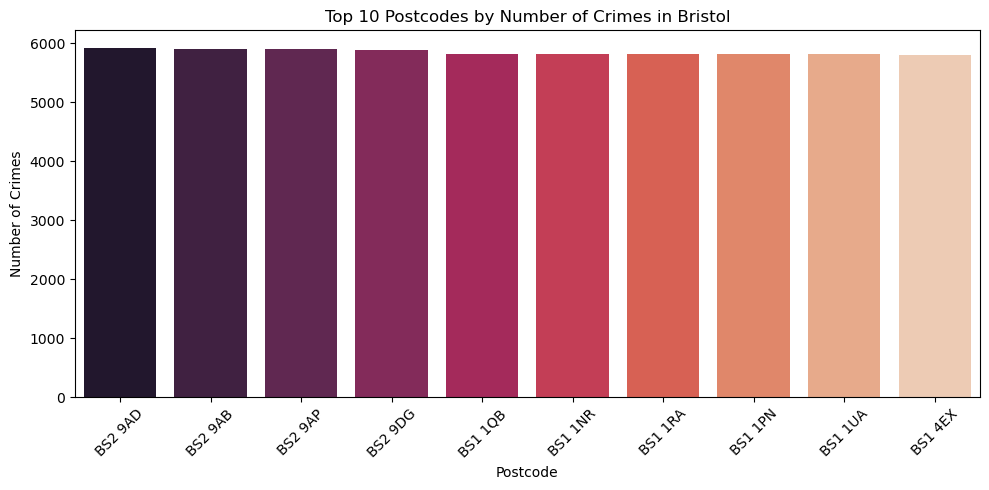

In [21]:
# Top 10 postcodes with most crime
top_postcodes = df['postcode'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=top_postcodes.values, palette="rocket")
plt.title('Top 10 Postcodes by Number of Crimes in Bristol')
plt.xlabel('Postcode')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

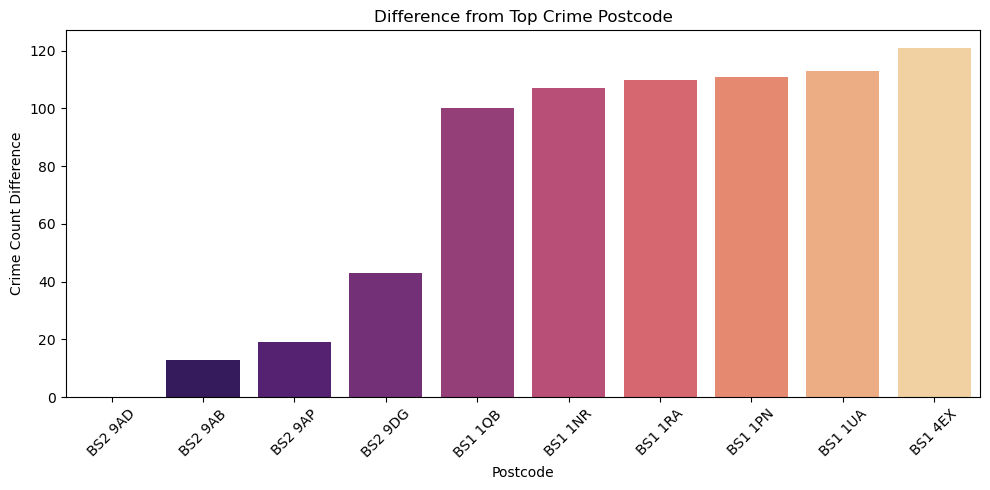

In [22]:
top_value = top_postcodes.values[0]
differences = top_value - top_postcodes.values

plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=differences, palette="magma")
plt.title('Difference from Top Crime Postcode')
plt.ylabel('Crime Count Difference')
plt.xlabel('Postcode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

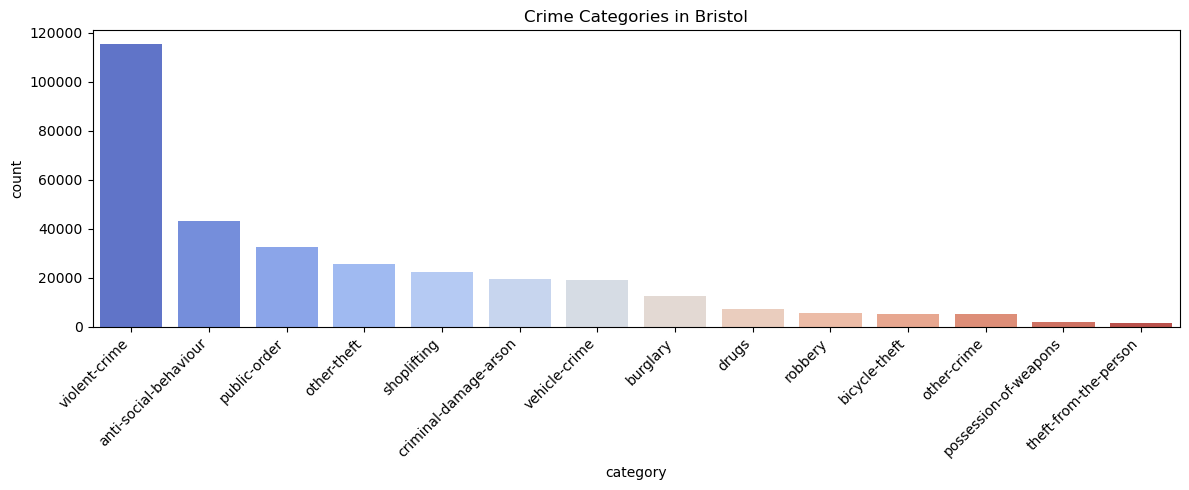

In [23]:
# Crime category vs Number of Crimes
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette="coolwarm")
plt.title('Crime Categories in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


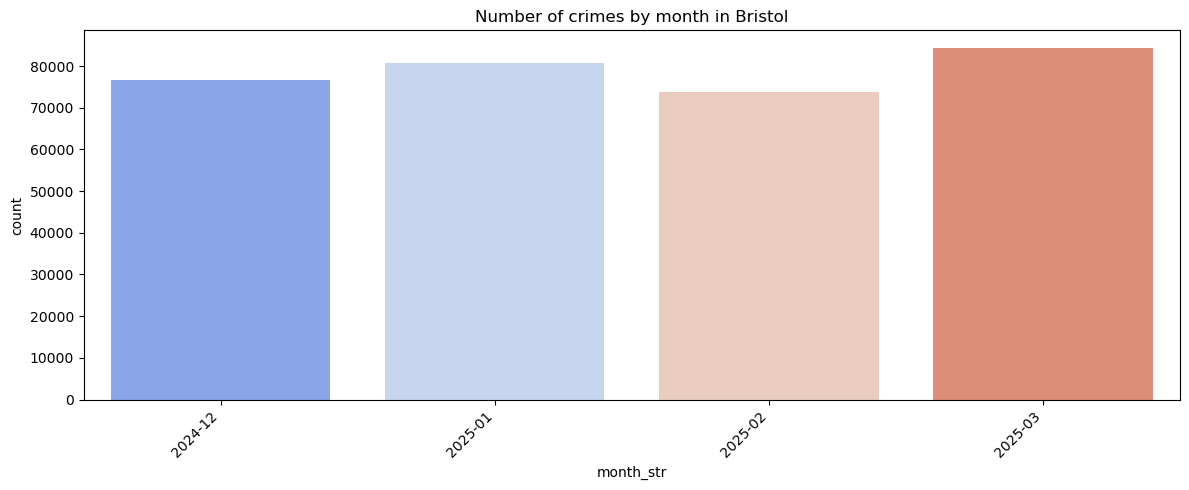

In [33]:
# Crimes by month
df['month'] = pd.to_datetime(df['month'])

# Extract year-month as string for plotting
df['month_str'] = df['month'].dt.strftime('%Y-%m')

# Sort months
sorted_months = df['month'].sort_values().dt.strftime('%Y-%m').unique()

# Plot
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='month_str', order=sorted_months, palette="coolwarm")
plt.title('Number of crimes by month in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [36]:
# Create map centred on Filton
crime_map = folium.Map(location=[51.454514, -2.587910], zoom_start=14)

import ast

# Convert 'location' column from string to dict if necessary
if isinstance(df['location'].iloc[0], str):
	df['location'] = df['location'].apply(ast.literal_eval)

# Filter out missing data
df = df[df['location'].notnull() & df['location'].apply(lambda loc: loc.get('latitude') and loc.get('longitude'))]

df['lat'] = df['location'].apply(lambda loc: float(loc['latitude']))
df['lng'] = df['location'].apply(lambda loc: float(loc['longitude']))

heat_data = df[['lat', 'lng']].values.tolist()

# Add heat effect to the map
HeatMap(heat_data, radius=15, blur=25, max_zoom=15).add_to(crime_map)

# Save map as HTML
crime_map.save("../assets/filton_crime_map.html")
print("Crime heatmap saved as filton_crime_map.html. Open it in a browser!")

Crime heatmap saved as filton_crime_map.html. Open it in a browser!


In [37]:
# Get all column names
df.columns

Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'postcode', 'lat',
       'lng'],
      dtype='object')

In [38]:
# Shape
df.shape

(315534, 12)

In [39]:
# Replace empty strings with NaN for uniformity
df_cleaned = df.replace('', np.nan)

# Total number of rows with missing values
df_cleaned.isna().sum()

category                 0
location_type            0
location                 0
context             315534
outcome_status       42944
persistent_id        43638
id                       0
location_subtype    314840
month                    0
postcode                 0
lat                      0
lng                      0
dtype: int64

In [40]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=['outcome_status', 'context', 'persistent_id', 'location_subtype', 'location_type'], axis=1)
df_cleaned.head()

,category,location,id,month,postcode,lat,lng
0,anti-social-behaviour,"{'latitude': '51.475311', 'street': {'id': 228...",126956014,2025-03,BS5 7AF,51.475311,-2.543218
1,anti-social-behaviour,"{'latitude': '51.458158', 'street': {'id': 228...",126954562,2025-03,BS5 7AF,51.458158,-2.565353
2,anti-social-behaviour,"{'latitude': '51.471261', 'street': {'id': 228...",126954573,2025-03,BS5 7AF,51.471261,-2.564795
3,anti-social-behaviour,"{'latitude': '51.457623', 'street': {'id': 228...",126954578,2025-03,BS5 7AF,51.457623,-2.560683
4,anti-social-behaviour,"{'latitude': '51.468156', 'street': {'id': 228...",126954591,2025-03,BS5 7AF,51.468156,-2.554190


In [41]:
# Regex pattern for YYYY-MM format
pattern = r'^\d{4}-(0[1-9]|1[0-2])$'

# Cound the number of invalid dates
valid_count = (~df_cleaned['month'].str.match(pattern)).sum()
print(f"Number of invalid dates: {valid_count}")

Number of invalid dates: 0


In [14]:
# Seperate Year and Month to different columns
# df_cleaned[["year", "month"]] = df["month"].str.split("-", expand = True)
# df_cleaned.head()

In [43]:
# Count crime categories
crime_category_count = df_cleaned['category'].value_counts()
print(crime_category_count)

violent-crime            115183
anti-social-behaviour     42944
public-order              32704
other-theft               25416
shoplifting               22456
criminal-damage-arson     19614
vehicle-crime             18934
burglary                  12344
drugs                      7055
robbery                    5407
bicycle-theft              5141
other-crime                5132
possession-of-weapons      1774
theft-from-the-person      1430
Name: category, dtype: int64


In [44]:
# Recategorised crimes to imporve generalisation
crime_category_map = {
    'violent-crime': 'violence',
    'robbery': 'violence',
    'shoplifting': 'theft',
    'burglary': 'theft',
    'vehicle-crime': 'theft',
    'bicycle-theft': 'theft',
    'theft-from-the-person': 'theft',
    'other-theft': 'theft',
    'anti-social-behaviour': 'anti-social',
    'public-order': 'anti-social',
    'criminal-damage-arson': 'anti-social',
    'drugs': 'drugs',
    'possession-of-weapons': 'other', 
    'other-crime': 'other'
}

df_cleaned['recategorised_crimes'] = df_cleaned['category'].map(crime_category_map)

# Assign any unmapped crimes to 'other' category
df_cleaned['recategorised_crimes'] = df_cleaned['recategorised_crimes'].fillna('other')

crime_category_count = df_cleaned['recategorised_crimes'].value_counts()
print(crime_category_count)

violence       120590
anti-social     95262
theft           85721
drugs            7055
other            6906
Name: recategorised_crimes, dtype: int64


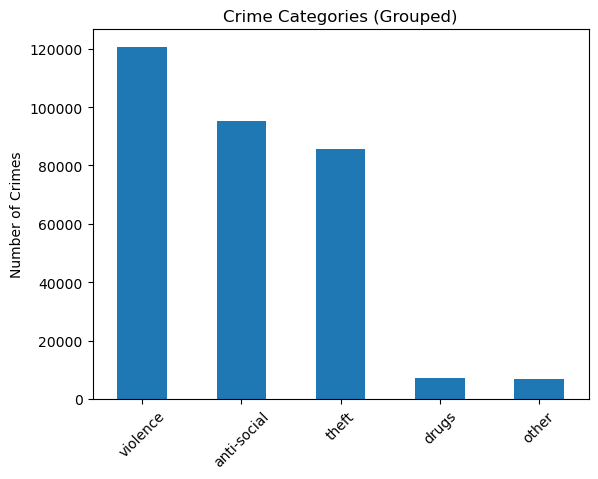

In [45]:
df_cleaned['recategorised_crimes'].value_counts().plot(kind='bar')
plt.title("Crime Categories (Grouped)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

In [46]:
# Total crimes per postcode
total_crimes_per_postcode = df_cleaned.groupby('postcode').size().reset_index(name='total_crimes')
print(total_crimes_per_postcode)

    postcode  total_crimes
0    BS1 1BU          5790
1    BS1 1DL          5778
2    BS1 1NR          5819
3    BS1 1PN          5815
4    BS1 1QB          5826
..       ...           ...
165  BS9 3RS           585
166  BS9 3RT           589
167  BS9 3SB           609
168  BS9 3SZ           632
169  BS9 3UA           616

[170 rows x 2 columns]


In [52]:
# Top crime category per postcode
top_category_per_postcode = (
    df_cleaned.groupby(['postcode', 'recategorised_crimes']).size().reset_index(name='count').sort_values(['postcode', 'count'], ascending=[True, False]).drop_duplicates('postcode').rename(columns={'recategorised_crimes': 'top_crime_category'}).drop('count', axis=1)
)
print(top_category_per_postcode)

    postcode top_crime_category
0    BS1 1BU        anti-social
5    BS1 1DL        anti-social
10   BS1 1NR        anti-social
15   BS1 1PN        anti-social
20   BS1 1QB        anti-social
..       ...                ...
828  BS9 3RS              theft
833  BS9 3RT              theft
838  BS9 3SB              theft
843  BS9 3SZ              theft
848  BS9 3UA              theft

[170 rows x 2 columns]


In [53]:
# Crimes per postcode per month
monthly_crime = (
    df_cleaned.groupby(['postcode', 'month'])
    .size()
    .reset_index(name='monthly_crimes')
)
print(monthly_crime)

    postcode    month  monthly_crimes
0    BS1 1BU  2024-12            1344
1    BS1 1BU  2025-01            1496
2    BS1 1BU  2025-02            1388
3    BS1 1BU  2025-03            1562
4    BS1 1DL  2024-12            1340
..       ...      ...             ...
675  BS9 3SZ  2025-03             166
676  BS9 3UA  2024-12             174
677  BS9 3UA  2025-01             142
678  BS9 3UA  2025-02             136
679  BS9 3UA  2025-03             164

[680 rows x 3 columns]


In [54]:
# Merge summaries into one master table
postcode_summary = total_crimes_per_postcode.merge(top_category_per_postcode, on='postcode')
print(postcode_summary)

    postcode  total_crimes top_crime_category
0    BS1 1BU          5790        anti-social
1    BS1 1DL          5778        anti-social
2    BS1 1NR          5819        anti-social
3    BS1 1PN          5815        anti-social
4    BS1 1QB          5826        anti-social
..       ...           ...                ...
165  BS9 3RS           585              theft
166  BS9 3RT           589              theft
167  BS9 3SB           609              theft
168  BS9 3SZ           632              theft
169  BS9 3UA           616              theft

[170 rows x 3 columns]


In [55]:
# Check time range
print(df_cleaned['month'].min(), df_cleaned['month'].max())

2024-12 2025-03


In [56]:
# Split by time
train = df_cleaned[df_cleaned['month'] <= '2025-02']
test = df_cleaned[df_cleaned['month'] == '2025-03']

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (231193, 8)
Test size: (84341, 8)


In [57]:
print(train['recategorised_crimes'].value_counts(normalize=True))
print(test['recategorised_crimes'].value_counts(normalize=True))

violence       0.388489
anti-social    0.300896
theft          0.267962
other          0.022713
drugs          0.019940
Name: recategorised_crimes, dtype: float64
violence       0.364876
anti-social    0.304680
theft          0.281832
drugs          0.028989
other          0.019623
Name: recategorised_crimes, dtype: float64
